In [1]:
import numpy as np 
import pandas as pd 
import datetime
import re
import os, os.path
import time
from sklearn.model_selection import train_test_split
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sb

In [2]:
cd ../Training_Data

/app/data/Training_Data


In [3]:
sb.set_palette("husl",4)
sb.set_style("whitegrid")

In [4]:
train_set = pd.read_csv('processed_train_set.csv',converters={'acceleration': eval})
test_set = pd.read_csv('processed_test_set.csv',converters={'acceleration': eval})
val_set = pd.read_csv('processed_val_set.csv',converters={'acceleration': eval})

In [3]:
cd ../Model


/app/data/Model


In [5]:
def calculate_model_size(model):
    print(model.summary())
    var_sizes = [
      np.product(list(map(int, v.shape))) * v.dtype.size
      for v in model.trainable_variables
      ]
    print("Model size:", sum(var_sizes) / 1024, "KB")

In [6]:
samples = len(train_set['acceleration'][0])

lstm_model = tf.keras.Sequential([
      tf.keras.layers.Bidirectional(
          tf.keras.layers.LSTM(22),
          input_shape=(samples, 3)),  # output_shape=(batch, 253)
      tf.keras.layers.Dense(4, activation="sigmoid")  # (batch, 4)
])

cnn_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(8, (4, 3),padding="same",activation="relu",
                           input_shape=(samples, 3, 1)),  # output_shape=(batch, 760, 3, 8)
    tf.keras.layers.MaxPool2D((3, 3)),  # (batch, 253, 1, 8)
    tf.keras.layers.Dropout(0.1),  # (batch, 253, 1, 8)
    tf.keras.layers.Conv2D(16, (4, 1), padding="same",activation="relu"), # (batch, 253, 1, 16)
    tf.keras.layers.MaxPool2D((3, 1), padding="same"),  # (batch, 84, 1, 16)
    tf.keras.layers.Dropout(0.1),  # (batch, 84, 1, 16)
    tf.keras.layers.Flatten(),  # (batch, 1344)
    tf.keras.layers.Dense(16, activation="relu"),  # (batch, 16)
    tf.keras.layers.Dropout(0.1),  # (batch, 16)
    tf.keras.layers.Dense(4, activation="softmax")  # (batch, 4)
])

cnn_model2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(8, (4, 3),padding="same",activation="relu",
                           input_shape=(samples, 3, 1)),  # output_shape=(batch, 760, 3, 8)
    tf.keras.layers.MaxPool2D((3, 3)),  # (batch, 253, 1, 8)
    tf.keras.layers.Dropout(0.1),  # (batch, 253, 1, 8)
    tf.keras.layers.Conv2D(16, (4, 1), padding="same",activation="relu"), # (batch, 253, 1, 16)
    tf.keras.layers.MaxPool2D((3, 1), padding="same"),  # (batch, 84, 1, 16)
    tf.keras.layers.Dropout(0.1),  # (batch, 84, 1, 16)
    tf.keras.layers.Flatten(),  # (batch, 1344)
    tf.keras.layers.Dense(16, activation="relu"),  # (batch, 16)
    tf.keras.layers.Dropout(0.1),  # (batch, 16)
    tf.keras.layers.Dense(4, activation="softmax")  # (batch, 4)
])

#unused
cnn_model3 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(8, (4, 3),padding="same",activation="relu",
                           input_shape=(samples, 3, 1)),  # output_shape=(batch, 760, 3, 8)
    tf.keras.layers.MaxPool2D((6, 3)),  # (batch, 126, 1, 8)
    tf.keras.layers.Dropout(0.1),  # (batch, 126, 1, 8)
    tf.keras.layers.Conv2D(16, (4, 1), padding="same",activation="relu"), # (batch, 126, 1, 16)
    tf.keras.layers.MaxPool2D((6, 1), padding="same"),  # (batch, 21, 1, 16)
    tf.keras.layers.Dropout(0.1),  # (batch, 21, 1, 16)
    tf.keras.layers.Flatten(),  # (batch, 336)
    tf.keras.layers.Dense(16, activation="relu"),  # (batch, 16)
    tf.keras.layers.Dropout(0.1),  # (batch, 16)
    tf.keras.layers.Dense(4, activation="softmax")  # (batch, 4)
])

In [7]:
tensor_train_set = tf.data.Dataset.from_tensor_slices(
    (np.array(train_set['acceleration'].tolist(),dtype=np.float64),
     train_set['gesture'].tolist()))

tensor_test_set = tf.data.Dataset.from_tensor_slices(
    (np.array(test_set['acceleration'].tolist(),dtype=np.float64),
     test_set['gesture'].tolist()))

tensor_val_set = tf.data.Dataset.from_tensor_slices(
    (np.array(val_set['acceleration'].tolist(),dtype=np.float64),
     val_set['gesture'].tolist()))

In [8]:
calculate_model_size(lstm_model)
epochs_cnn = 20
epochs_lstm = 20
batch_size = 64
batch_size2 = 192

lstm_model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])

calculate_model_size(cnn_model)
cnn_model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])

calculate_model_size(cnn_model2)
cnn_model2.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])

calculate_model_size(cnn_model3)
cnn_model3.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 44)                4576      
_________________________________________________________________
dense (Dense)                (None, 4)                 180       
Total params: 4,756
Trainable params: 4,756
Non-trainable params: 0
_________________________________________________________________
None
Model size: 18.578125 KB
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 760, 3, 8)         104       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 253, 1, 8)         0         
_________________________________________________________________
dropout (Dropout)            (None, 253, 1, 8)         0         
__

In [13]:
tensor_train_set_lstm = tensor_train_set.batch(batch_size).repeat()
tensor_val_set_lstm = tensor_val_set.batch(batch_size)
tensor_test_set_lstm = tensor_test_set.batch(batch_size)

In [23]:
history = lstm_model.fit(
    tensor_train_set_lstm,
    epochs=epochs_lstm,
    validation_data=tensor_val_set_lstm,
    steps_per_epoch=200,
    validation_steps=int((len(val_set) - 1) / batch_size + 1))

Epoch 1/20
200/200 [==============================] - 50s 252ms/step - loss: 1.1708 - accuracy: 0.5038 - val_loss: 1.2219 - val_accuracy: 0.3824
Epoch 2/20
200/200 [==============================] - 50s 250ms/step - loss: 0.9475 - accuracy: 0.6209 - val_loss: 1.0014 - val_accuracy: 0.5588
Epoch 3/20
200/200 [==============================] - 50s 251ms/step - loss: 0.6700 - accuracy: 0.7546 - val_loss: 0.7682 - val_accuracy: 0.6176
Epoch 4/20
200/200 [==============================] - 50s 251ms/step - loss: 0.6416 - accuracy: 0.7543 - val_loss: 0.7650 - val_accuracy: 0.7647
Epoch 5/20
200/200 [==============================] - 49s 247ms/step - loss: 0.5170 - accuracy: 0.7993 - val_loss: 0.6845 - val_accuracy: 0.7941
Epoch 6/20
200/200 [==============================] - 41s 205ms/step - loss: 0.4968 - accuracy: 0.8175 - val_loss: 0.5047 - val_accuracy: 0.8529
Epoch 7/20
200/200 [==============================] - 44s 220ms/step - loss: 0.3459 - accuracy: 0.8813 - val_loss: 0.4133 - val_ac

In [24]:
loss_lstm, acc_lstm = lstm_model.evaluate(tensor_test_set_lstm)
pred_lstm = np.argmax(lstm_model.predict(tensor_test_set_lstm), axis=1)
confusion_lstm = tf.math.confusion_matrix(
    labels=tf.constant(test_set['gesture'].to_numpy()),
    predictions=tf.constant(pred_lstm),
    num_classes=4)

1/1 [==============================] - 0s 841us/step - loss: 0.0479 - accuracy: 1.0000


In [25]:
print(confusion_lstm)
print("Loss {}, Accuracy {}".format(loss_lstm, acc_lstm))

tf.Tensor(
[[14  0  0  0]
 [ 0 10  0  0]
 [ 0  0 14  0]
 [ 0  0  0  8]], shape=(4, 4), dtype=int32)
Loss 0.04790152609348297, Accuracy 1.0


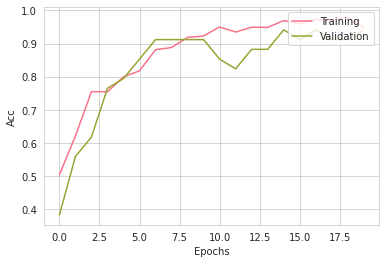

In [26]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend(['Training','Validation'],loc='upper right')

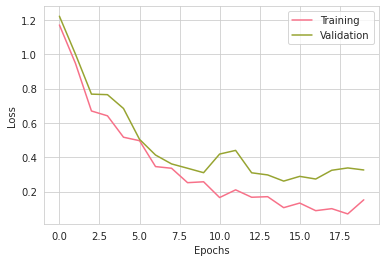

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training','Validation'],loc='upper right')

In [28]:
converter = tf.lite.TFLiteConverter.from_keras_model(lstm_model)
lstm_tflite_model = converter.convert()

open("lstm_model.tflite", "wb").write(lstm_tflite_model)

121340

In [31]:
lstm_model.save('lstm_model.h5') 

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(lstm_model)
converter.experimental_new_converter = True
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
converter.target_spec.supported_types = [tf.float16]
lstm_opt_tflite_model = converter.convert()
# Save the model to disk
open("lstm_model_quantized.tflite", "wb").write(lstm_opt_tflite_model)

In [18]:
basic_model_size = os.path.getsize("../Model/lstm_model.tflite")
print("Basic model is %d bytes" % basic_model_size)
#quantized_model_size = os.path.getsize("lstm_model_quantized.tflite")
#print("Quantized model is %d bytes" % quantized_model_size)
#difference = basic_model_size - quantized_model_size
#print("Difference is %d bytes" % difference)

Basic model is 121340 bytes


In [9]:
def reshape_function(data, label):
    reshaped_data = tf.reshape(data, [-1, 3, 1])
    return reshaped_data, label

In [ ]:
train_set = pd.read_csv('processed_train_set.csv',converters={'acceleration': eval})
test_set = pd.read_csv('processed_test_set.csv',converters={'acceleration': eval})
val_set = pd.read_csv('processed_val_set.csv',converters={'acceleration': eval})

tensor_train_set = tf.data.Dataset.from_tensor_slices(
    (np.array(train_set['acceleration'].tolist(),dtype=np.float64),
     train_set['gesture'].tolist()))

tensor_test_set = tf.data.Dataset.from_tensor_slices(
    (np.array(test_set['acceleration'].tolist(),dtype=np.float64),
     test_set['gesture'].tolist()))

tensor_val_set = tf.data.Dataset.from_tensor_slices(
    (np.array(val_set['acceleration'].tolist(),dtype=np.float64),
     val_set['gesture'].tolist()))

In [10]:
tensor_train_set_cnn = tensor_train_set.map(reshape_function)
tensor_test_set_cnn = tensor_test_set.map(reshape_function)
tensor_val_set_cnn = tensor_val_set.map(reshape_function)

In [11]:
tensor_train_set_cnn = tensor_train_set_cnn.batch(batch_size).repeat()
tensor_test_set_cnn = tensor_test_set_cnn.batch(batch_size)
tensor_val_set_cnn = tensor_val_set_cnn.batch(batch_size)

In [19]:
history=cnn_model.fit(
    tensor_train_set_cnn,
    epochs=epochs_cnn,
    validation_data=tensor_val_set_cnn,
    steps_per_epoch=300,
    validation_steps=int((len(val_set) - 1) / batch_size + 1))

Epoch 1/20
300/300 [==============================] - 10s 33ms/step - loss: 0.7721 - accuracy: 0.7594 - val_loss: 0.3392 - val_accuracy: 0.9118
Epoch 2/20
300/300 [==============================] - 10s 33ms/step - loss: 0.3129 - accuracy: 0.8943 - val_loss: 0.1897 - val_accuracy: 0.9412
Epoch 3/20
300/300 [==============================] - 10s 33ms/step - loss: 0.1923 - accuracy: 0.9358 - val_loss: 0.3340 - val_accuracy: 0.8824
Epoch 4/20
300/300 [==============================] - 10s 34ms/step - loss: 0.1640 - accuracy: 0.9454 - val_loss: 0.3249 - val_accuracy: 0.8824
Epoch 5/20
300/300 [==============================] - 10s 33ms/step - loss: 0.1149 - accuracy: 0.9611 - val_loss: 0.2652 - val_accuracy: 0.9412
Epoch 6/20
300/300 [==============================] - 10s 34ms/step - loss: 0.0996 - accuracy: 0.9690 - val_loss: 0.2831 - val_accuracy: 0.9412
Epoch 7/20
300/300 [==============================] - 10s 33ms/step - loss: 0.0940 - accuracy: 0.9696 - val_loss: 0.3103 - val_accuracy:

In [26]:
history2=cnn_model2.fit(
    tensor_train_set_cnn,
    epochs=epochs_cnn,
    validation_data=tensor_val_set_cnn,
    steps_per_epoch=300,
    validation_steps=int((len(val_set) - 1) / batch_size2 + 1))

Epoch 1/20
300/300 [==============================] - 10s 33ms/step - loss: 0.9488 - accuracy: 0.6922 - val_loss: 0.5771 - val_accuracy: 0.8125
Epoch 2/20
300/300 [==============================] - 10s 33ms/step - loss: 0.4955 - accuracy: 0.8208 - val_loss: 0.2279 - val_accuracy: 0.9062
Epoch 3/20
300/300 [==============================] - 10s 33ms/step - loss: 0.2614 - accuracy: 0.9044 - val_loss: 0.2009 - val_accuracy: 0.8750
Epoch 4/20
300/300 [==============================] - 10s 34ms/step - loss: 0.2109 - accuracy: 0.9215 - val_loss: 0.1012 - val_accuracy: 0.9688
Epoch 5/20
300/300 [==============================] - 10s 33ms/step - loss: 0.1276 - accuracy: 0.9553 - val_loss: 0.0719 - val_accuracy: 0.9688
Epoch 6/20
300/300 [==============================] - 10s 32ms/step - loss: 0.1157 - accuracy: 0.9600 - val_loss: 0.1028 - val_accuracy: 0.9688
Epoch 7/20
300/300 [==============================] - 10s 32ms/step - loss: 0.1034 - accuracy: 0.9640 - val_loss: 0.1854 - val_accuracy:

In [27]:
loss_cnn, acc_cnn = cnn_model.evaluate(tensor_test_set_cnn)
pred_cnn = np.argmax(cnn_model.predict(tensor_test_set_cnn), axis=1)
confusion_cnn = tf.math.confusion_matrix(
    labels=tf.constant(test_set['gesture'].to_numpy()),
    predictions=tf.constant(pred_cnn),
    num_classes=4)

loss_cnn2, acc_cnn2 = cnn_model2.evaluate(tensor_test_set_cnn)
pred_cnn2 = np.argmax(cnn_model2.predict(tensor_test_set_cnn), axis=1)
confusion_cnn2 = tf.math.confusion_matrix(
    labels=tf.constant(test_set['gesture'].to_numpy()),
    predictions=tf.constant(pred_cnn2),
    num_classes=4)

1/1 [==============================] - 0s 2ms/step - loss: 0.2153 - accuracy: 0.9565


In [28]:
print(confusion_cnn)
print("Loss {}, Accuracy {}".format(loss_cnn, acc_cnn))
print(confusion_cnn2)
print("Loss {}, Accuracy {}".format(loss_cnn2, acc_cnn2))

tf.Tensor(
[[14  0  0  0]
 [ 0 10  0  0]
 [ 0  0 14  0]
 [ 0  0  0  8]], shape=(4, 4), dtype=int32)
Loss 0.013968262821435928, Accuracy 1.0
tf.Tensor(
[[14  0  0  0]
 [ 0 10  0  0]
 [ 0  0 14  0]
 [ 2  0  0  6]], shape=(4, 4), dtype=int32)
Loss 0.21532900631427765, Accuracy 0.95652174949646


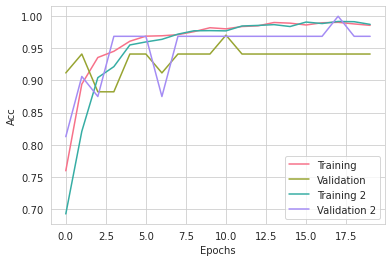

In [29]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])


plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])

plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend(['Training','Validation','Training 2', 'Validation 2'],loc='lower right')


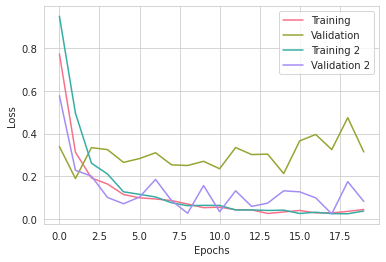

In [30]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])


plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training','Validation','Training 2', 'Validation 2'],loc='upper right')



Overfitting if: training loss << validation loss

Underfitting if: training loss >> validation loss

In [36]:
cnn_model3.save('cnn_model3.h5') 

In [38]:
converter = tf.lite.TFLiteConverter.from_keras_model(cnn_model3)
cnn_tflite_model = converter.convert()

open("../Model/cnn_model3.tflite", "wb").write(cnn_tflite_model)

27196

In [39]:
converter = tf.lite.TFLiteConverter.from_keras_model(cnn_model3)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
cnn_opt_tflite_model = converter.convert()
# Save the model to disk
open("../Model/cnn_model_quantized3.tflite", "wb").write(cnn_opt_tflite_model)

11312

In [40]:
basic_model_size = os.path.getsize("../Model/cnn_model3.tflite")
print("Basic model is %d bytes" % basic_model_size)
quantized_model_size = os.path.getsize("../Model/cnn_model_quantized3.tflite")
print("Quantized model is %d bytes" % quantized_model_size)
difference = basic_model_size - quantized_model_size
print("Difference is %d bytes" % difference)

Basic model is 27196 bytes
Quantized model is 11312 bytes
Difference is 15884 bytes


In [ ]:
# Install xxd if it is not available
#!apt-get -qq install xxd
# Save the file as a C source file
#!xxd -i cnn_model_quantized.tflite > cnn_opt_model.cc
# Print the source file
#!cat /cnn_opt_model.cc

In [12]:
history3=cnn_model3.fit(
    tensor_train_set_cnn,
    epochs=epochs_cnn,
    validation_data=tensor_val_set_cnn,
    steps_per_epoch=300,
    validation_steps=int((len(val_set) - 1) / batch_size2 + 1))

Epoch 1/20
300/300 [==============================] - 9s 30ms/step - loss: 1.0525 - accuracy: 0.6501 - val_loss: 0.4469 - val_accuracy: 0.9531
Epoch 2/20
300/300 [==============================] - 9s 29ms/step - loss: 0.4852 - accuracy: 0.8396 - val_loss: 0.1570 - val_accuracy: 0.9688
Epoch 3/20
300/300 [==============================] - 9s 29ms/step - loss: 0.2820 - accuracy: 0.9014 - val_loss: 0.1943 - val_accuracy: 0.9375
Epoch 4/20
300/300 [==============================] - 9s 29ms/step - loss: 0.2315 - accuracy: 0.9130 - val_loss: 0.1676 - val_accuracy: 0.9375
Epoch 5/20
300/300 [==============================] - 9s 29ms/step - loss: 0.1588 - accuracy: 0.9435 - val_loss: 0.1557 - val_accuracy: 0.9688
Epoch 6/20
300/300 [==============================] - 9s 29ms/step - loss: 0.1400 - accuracy: 0.9525 - val_loss: 0.0484 - val_accuracy: 0.9688
Epoch 7/20
300/300 [==============================] - 9s 30ms/step - loss: 0.1408 - accuracy: 0.9532 - val_loss: 0.1127 - val_accuracy: 0.9688

In [35]:
loss_cnn3, acc_cnn3 = cnn_model3.evaluate(tensor_test_set_cnn)
pred_cnn3 = np.argmax(cnn_model3.predict(tensor_test_set_cnn), axis=1)
confusion_cnn3 = tf.math.confusion_matrix(
    labels=tf.constant(test_set['gesture'].to_numpy()),
    predictions=tf.constant(pred_cnn3),
    num_classes=4)

print(confusion_cnn2)
print("Loss {}, Accuracy {}".format(loss_cnn2, acc_cnn2))

print(confusion_cnn3)
print("Loss {}, Accuracy {}".format(loss_cnn3, acc_cnn3))

1/1 [==============================] - 0s 1ms/step - loss: 0.0152 - accuracy: 1.0000
tf.Tensor(
[[14  0  0  0]
 [ 0 10  0  0]
 [ 0  0 14  0]
 [ 2  0  0  6]], shape=(4, 4), dtype=int32)
Loss 0.21532900631427765, Accuracy 0.95652174949646
tf.Tensor(
[[14  0  0  0]
 [ 0 10  0  0]
 [ 0  0 14  0]
 [ 0  0  0  8]], shape=(4, 4), dtype=int32)
Loss 0.015218148939311504, Accuracy 1.0


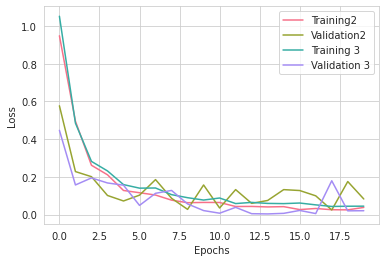

In [33]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])

plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training2','Validation2','Training 3', 'Validation 3'],loc='upper right')

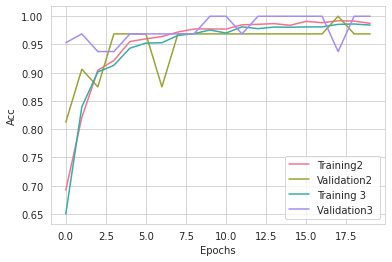

In [34]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])

plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])

plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend(['Training2','Validation2','Training 3', 'Validation3 '],loc='lower right')

In [42]:
!xxd -i ../Model/cnn_model_quantized3.tflite > ../Model/cnn_opt_model3.cc

In [43]:
!cat ../Model/cnn_opt_model3.cc

unsigned char ___Model_cnn_model_quantized3_tflite[] = {
  0x20, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x00, 0x00, 0x00, 0x00,
  0x00, 0x00, 0x12, 0x00, 0x1c, 0x00, 0x04, 0x00, 0x08, 0x00, 0x0c, 0x00,
  0x10, 0x00, 0x14, 0x00, 0x00, 0x00, 0x18, 0x00, 0x12, 0x00, 0x00, 0x00,
  0x03, 0x00, 0x00, 0x00, 0xac, 0x2b, 0x00, 0x00, 0x40, 0x22, 0x00, 0x00,
  0x28, 0x22, 0x00, 0x00, 0x3c, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00,
  0x01, 0x00, 0x00, 0x00, 0x0c, 0x00, 0x00, 0x00, 0x08, 0x00, 0x0c, 0x00,
  0x04, 0x00, 0x08, 0x00, 0x08, 0x00, 0x00, 0x00, 0x08, 0x00, 0x00, 0x00,
  0x13, 0x00, 0x00, 0x00, 0x13, 0x00, 0x00, 0x00, 0x6d, 0x69, 0x6e, 0x5f,
  0x72, 0x75, 0x6e, 0x74, 0x69, 0x6d, 0x65, 0x5f, 0x76, 0x65, 0x72, 0x73,
  0x69, 0x6f, 0x6e, 0x00, 0x14, 0x00, 0x00, 0x00, 0xd8, 0x21, 0x00, 0x00,
  0xc4, 0x21, 0x00, 0x00, 0x88, 0x21, 0x00, 0x00, 0x34, 0x21, 0x00, 0x00,
  0xe0, 0x20, 0x00, 0x00, 0xbc, 0x20, 0x00, 0x00, 0x98, 0x20, 0x00, 0x00,
  0x84, 0x0b, 0x00, 0x00, 0x70, 0x0a, 0x00, 0x00, 0xdc,